In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Cargar y limpiar datos

In [3]:
housing = pd.read_csv('data/housing.csv')
housing = pd.get_dummies(housing, drop_first=True)
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean())
target = 'median_house_value'
X = housing.copy().drop(target, axis=1)
y = housing[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
# Ejempolo gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=4)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=300)

In [5]:
predicciones = model.predict(X_test)
r2_score(y_test, predicciones)

0.8201094620442102

In [6]:
## Cross validation 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('gbt', GradientBoostingRegressor(n_estimators=300))
])
params = {
    'gbt__max_depth': [2, 3, 4, 5],
    'gbt__learning_rate': [0.1, 0.5, 0.01]
}

grid_gbt = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='r2').fit(X_train, y_train)

grid_gbt.best_estimator_.named_steps['gbt']

In [7]:
# Mejor estimador
grid_gbt.best_params_

{'gbt__learning_rate': 0.1, 'gbt__max_depth': 5}

In [8]:
# r2 score
best_model = grid_gbt.best_estimator_.named_steps['gbt']
predicciones = best_model.predict(X_test)
r2_score(y_test, predicciones)

0.8284056711034131

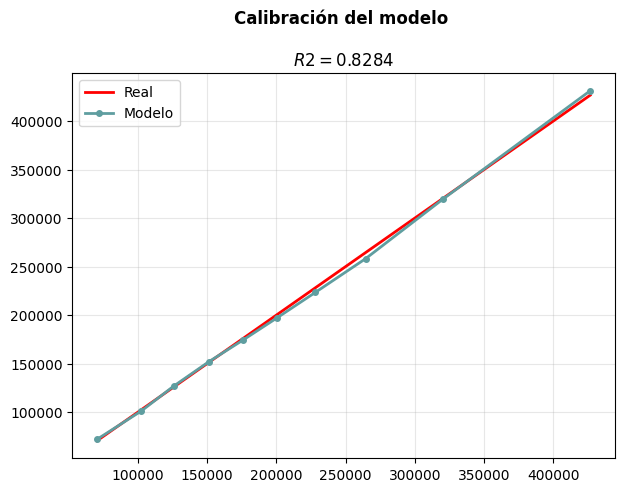

In [11]:
## Calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
        
    # Gráfica
    plt.figure(figsize=(7,5))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=2)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=4, lw=2)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$', fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()

calibracion(predicciones, y_test, 10)

In [13]:
# Entendiendo el modelo 
importancia = pd.DataFrame({
    'features': X_train.columns,
    'importancia': best_model.feature_importances_
})
importancia.sort_values('importancia', ascending=False)

,features,importancia
7,median_income,0.527259
8,ocean_proximity_INLAND,0.149411
0,longitude,0.101985
1,latitude,0.082540
2,housing_median_age,0.043935
5,population,0.032925
4,total_bedrooms,0.026659
3,total_rooms,0.014671
6,households,0.011603
11,ocean_proximity_NEAR OCEAN,0.007164


    PartialDependenceDisplay.from_estimator(
        best_grid_gbt,
        X_train,
        [i],
        feature_names=X_train.columns
    )

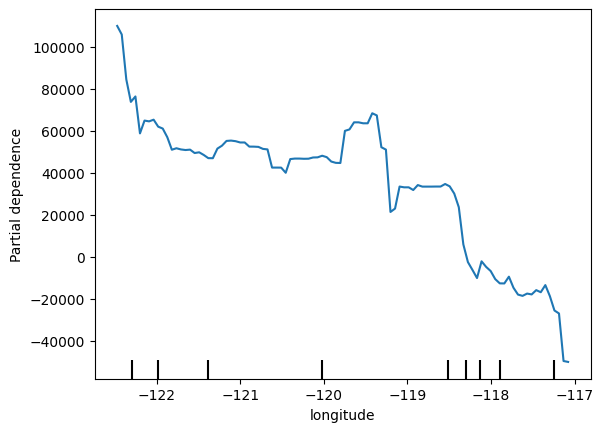

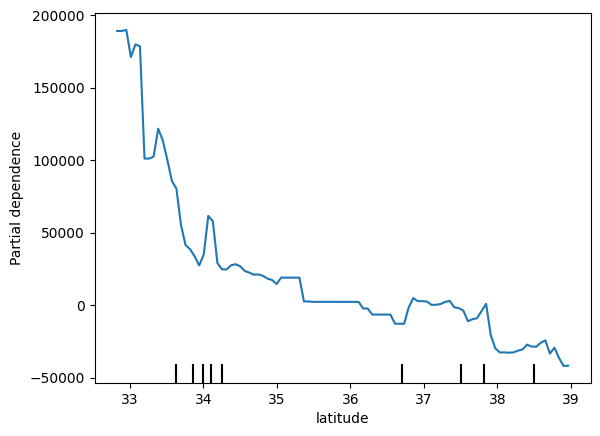

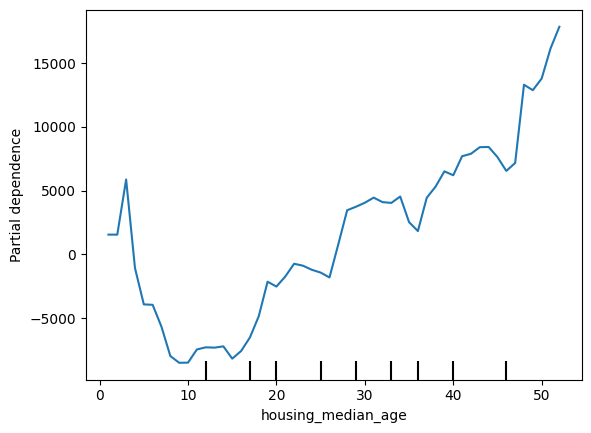

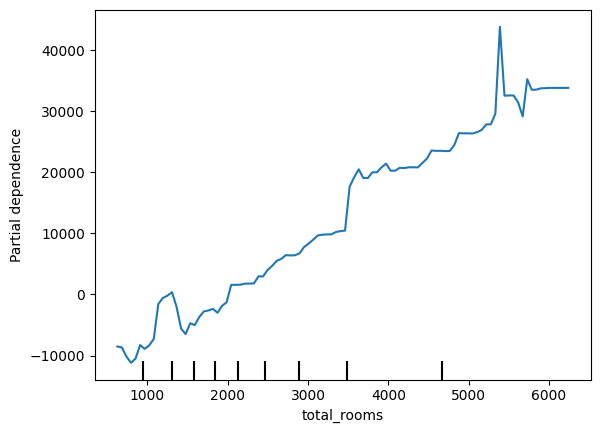

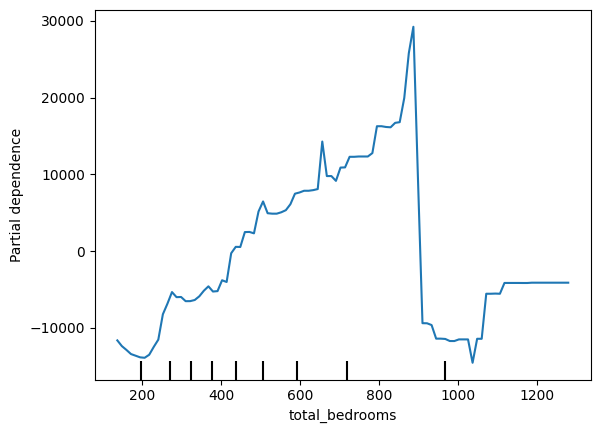

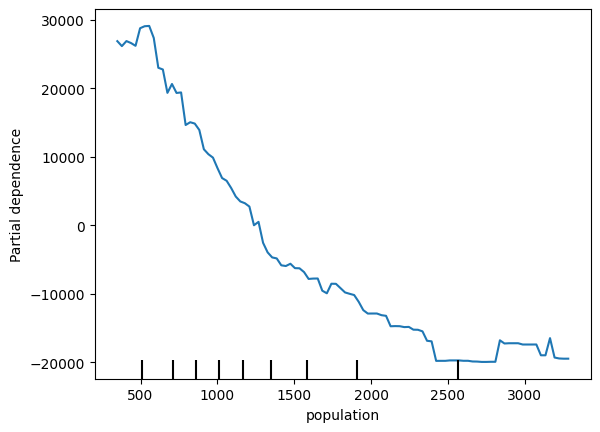

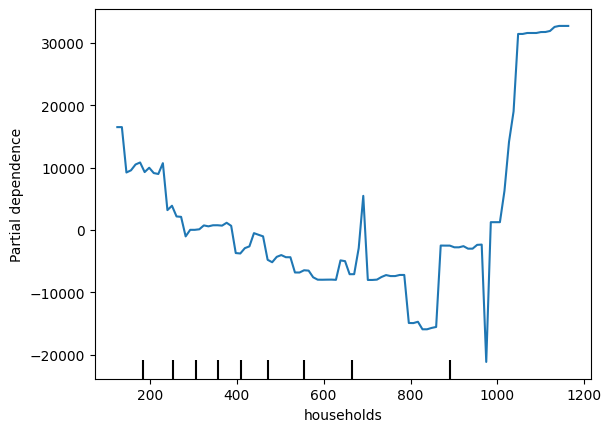

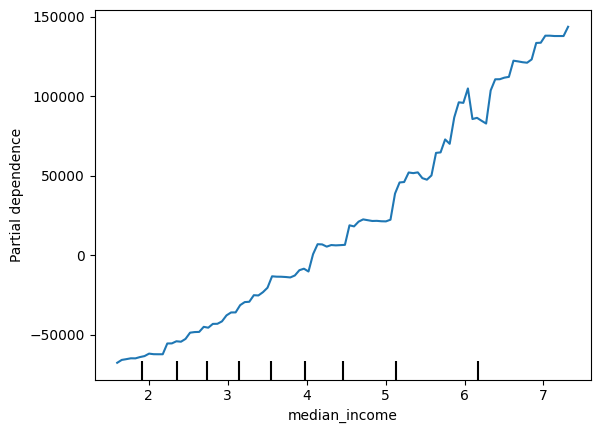

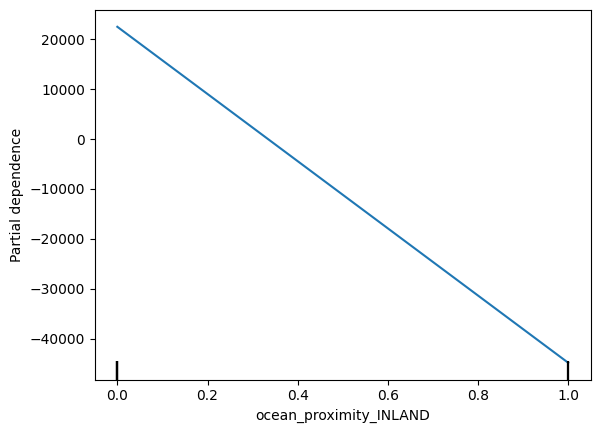

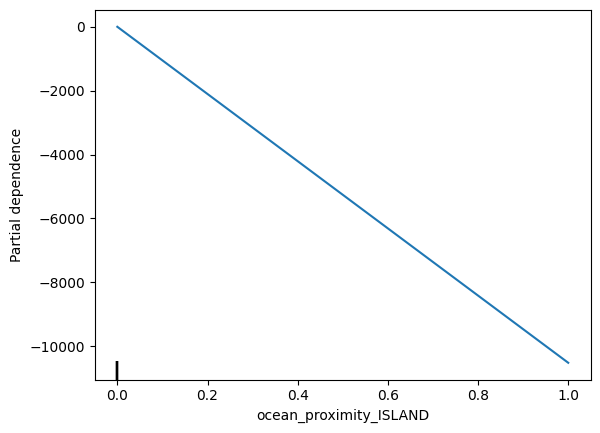

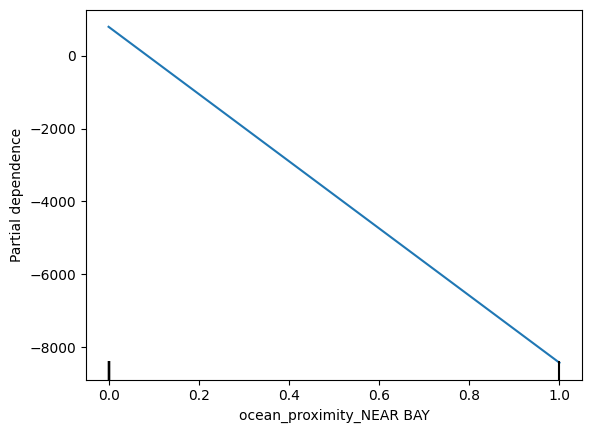

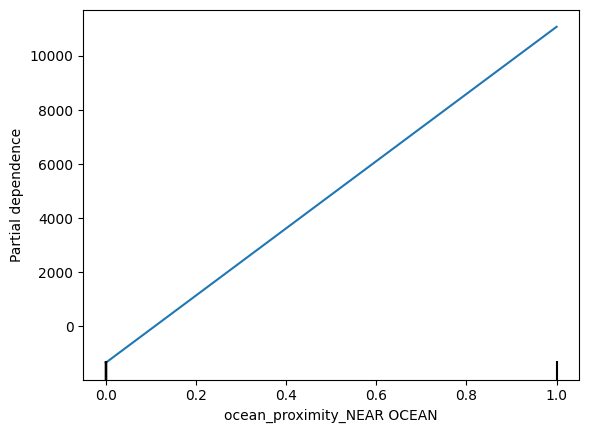

In [14]:
# Codigo for para partial dependence plot 
from sklearn.inspection import PartialDependenceDisplay

for i in range(len(X_train.columns)):
    PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    [i],
    feature_names=X_train.columns
    )